# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn import preprocessing
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics.cluster import adjusted_rand_score

# Funções e Classes

In [9]:
def matching_per_dissim_matrix(i, prototypes, j):

    dissim_matrix = dissim_matrices[j]
    dissimilarity = dissim_matrix[i][prototypes].sum()

    return dissimilarity

def matching_function(i, k, prototypes):
  
    weighted_matches = [Lambda[k, j] * matching_per_dissim_matrix(i, prototypes, j) for j in range(p)]
    matching_to_cluster = np.array(weighted_matches).sum()

    return matching_to_cluster

def homogeneity_intra_cluster(k, prototypes):

    membership_degrees = U[:, k]
    membership_degrees = np.power(membership_degrees, m)
    cluster_matches = [matching_function(i, k, prototypes) for i in range(n)]
    homogeneity_cluster = np.multiply(membership_degrees, cluster_matches).sum()

    return homogeneity_cluster

def adequacy_criterion():

    homogeneities = [homogeneity_intra_cluster(k, G[k, :]) for k in range(K)]
    sum_homogeneities = np.array(homogeneities).sum()

    return sum_homogeneities

def best_prototypes():

    prototypes = np.zeros([K, q], dtype=int)

    for k in range(K):

        candidates_homogeneities = [homogeneity_intra_cluster(k, [h]) for h in range(n)]
        homogeneities_series = pd.Series(candidates_homogeneities)
        homogeneities_sorted = homogeneities_series.sort_values()
                
        # Não selecionar protótipos já definidos para outros clusters na tentativa de gerar maior diversidade. 
        best_protos = []
        i = 0
        while len(best_protos) < q:
            if homogeneities_sorted.index[i] not in prototypes:
                best_protos.append(homogeneities_sorted.index[i])
            i += 1
        
        prototypes[k] = best_protos

    return prototypes

def best_relevance_weights():

    relevance_weights = np.ones([K, p])

    if p == 1: # Com uma única matriz de dissimilaridade não há o conceito de 'relevance weights'.
        return relevance_weights

    for k in range(K):

        membership_degrees = np.power(U[:, k], m)
        prototypes = G[k, :]

        dissims_per_matrix_list = [dissim_matrices[h][:, prototypes].sum(axis=1) for h in range(p)]
        homogen_list = [np.multiply(membership_degrees, dissims_per_matrix_list[h]).sum() for h in range(p)]

        numerator = np.prod(homogen_list)**(1/p)

        relevance_weights[k] = [numerator / homogen_list[j] for j in range(p)]

    return relevance_weights

def best_fuzzy_partition():

    fuzzy_partition = np.empty((n, K))

    for i in range(n):

        if i in G: # Este elto eh 'compartilhado' igualitariamente entre os clusters os quais eh representante, zerando u_ik p/ o resto.

            which_clusters = [1 if i in G[k] else 0 for k in range(K)] # Onde i é protótipo?
            which_clusters = np.array(which_clusters, dtype='float64')

            how_many_clusters = which_clusters.sum() # i é protótipo de quantos grupos?
            membership_degrees = which_clusters * 1/how_many_clusters

            fuzzy_partition[i] = membership_degrees

        else:

            for k in range(K):

                exp = 1 / (m - 1)
                numerator = matching_function(i, k, G[k, :])
                dist_proportions = [(numerator / matching_function(i, h, G[h, :])) ** exp for h in range(K)]

                membership_degree = np.array(dist_proportions).sum()
                membership_degree **= -1

                fuzzy_partition[i, k] = membership_degree

    return fuzzy_partition

class Experiment:

    prototypes = None
    relevance_weights = None
    fuzzy_partition = None
    adequacy_criterion = None
    iterations = None

    crisp_partition = None
    expand_confusion_matrix = None

    def partition_coeff(self):

        membership_squared = np.power(self.fuzzy_partition, 2)
        Vpc = membership_squared.sum() / n

        return Vpc

    def mod_partition_coeff(self):

        Vpc = self.partition_coeff()
        Vmpc = 1 - (K/(K-1)) * (1 - Vpc)

        return Vmpc

    def partition_entropy(self):

        memberships = self.fuzzy_partition.copy()

        # log(0) eh indefinido. Tem que tratar algumas entradas para nao dar erro.
        # Mas, como multiplica-se por u_ik depois, onde esses u_ik's = 0, o valor resultante eh zero.
        memberships[memberships == 0] = 1e-15
        membership_log = np.log(memberships)

        Vpe = np.multiply(self.fuzzy_partition, membership_log).sum()
        Vpe *= -1/n

        return Vpe

    def fuzzy_to_crisp(self):

        predicted_labels = [np.argmax(self.fuzzy_partition[i, :]) for i in range(n)]

        self.crisp_partition = np.array(predicted_labels)

    def adjusted_rand_index(self):

        ar_index = adjusted_rand_score(true_labels, self.crisp_partition)

        return ar_index

    def confusion_matrix(self):

        original_matrix = contingency_matrix(true_labels, self.crisp_partition)

        cardinality_clusters = original_matrix.sum(axis=0)
        cardinality_clusters = np.array([cardinality_clusters])
        expanded_matrix = np.append(original_matrix, cardinality_clusters, axis=0)

        cardinality_classes = original_matrix.sum(axis=1)
        expand_card_classes = np.append(cardinality_classes, n)
        expand_card_classes = np.array([expand_card_classes]).T
        expanded_matrix = np.concatenate((expanded_matrix, expand_card_classes), axis=1)

        self.expand_confusion_matrix = expanded_matrix

    def partial_f_measure(self, i, j):

        n_ij = self.expand_confusion_matrix[i][j]

        if n_ij == 0:
            return 0

        precision_ij = n_ij / self.expand_confusion_matrix[-1][j]
        recall_ij = n_ij / self.expand_confusion_matrix[i][-1]

        F1_ij = 2 * (precision_ij * recall_ij) / (precision_ij + recall_ij)

        return F1_ij

    def max_partial_f_measure(self, i):

        num_clusters = self.expand_confusion_matrix.shape[1] - 1

        partial_f_measures = [self.partial_f_measure(i, j) for j in range(num_clusters)]
        max_partial_F1 = np.array(partial_f_measures).max()

        return max_partial_F1

    def f_measure(self):

        num_classes = self.expand_confusion_matrix.shape[0] - 1
        max_partial_f_measures = [self.max_partial_f_measure(i) for i in range(num_classes)]

        class_cardinalities = self.expand_confusion_matrix[:-1,-1]

        cards_by_partialF1 = np.multiply(class_cardinalities, np.array(max_partial_f_measures))

        F1 = cards_by_partialF1.sum() / n

        return F1

    def classification_error_rate(self):

        original_matrix = self.expand_confusion_matrix[:-1,:-1]
        accuracy = np.amax(original_matrix, axis=0).sum() / n
        overall_error = 1 - accuracy

        return overall_error
    
def run_experiments():
    global G, Lambda, U
    
    best_experiment = Experiment()
    best_experiment.adequacy_criterion = float('Inf')

    adequacy_criterions = []

    for num_experiment in range(num_max_experiments):

        print("EXPERIMENTO", num_experiment)

        G = np.random.choice(n, (K,q), replace=False)
        Lambda = np.ones([K, p])
        U = best_fuzzy_partition()
        previous_J = adequacy_criterion()

        for t in range(T):

            print(t)

            G = best_prototypes()
            Lambda = best_relevance_weights()
            U = best_fuzzy_partition()

            current_J = adequacy_criterion()

            if abs(current_J - previous_J) <= epsilon:
                break

            previous_J = current_J

        adequacy_criterions.append(current_J)
        if current_J < best_experiment.adequacy_criterion:

            best_experiment.prototypes = G
            best_experiment.relevance_weights = Lambda
            best_experiment.fuzzy_partition = U
            best_experiment.adequacy_criterion = current_J
            best_experiment.iterations = t
    
    return best_experiment, adequacy_criterions

# Base de Dados

In [10]:
base_URL = '../data/mfeat-'

scaler = preprocessing.MinMaxScaler()

## mfeat-fac (VIEW1): 216 Profile Correlations

In [5]:
dataset_name = 'fac'
view1_data = pd.read_csv(base_URL + dataset_name, delim_whitespace=True, header=None)

view1_scaled_data = scaler.fit_transform(view1_data)

view1_dissim_matrix = euclidean_distances(view1_scaled_data)
view1_dissim_matrix

array([[0.        , 1.72588593, 1.86992771, ..., 4.04045739, 3.80502234,
        4.600745  ],
       [1.72588593, 0.        , 1.57167923, ..., 3.68046119, 3.2365864 ,
        4.1536858 ],
       [1.86992771, 1.57167923, 0.        , ..., 3.9692168 , 3.42356504,
        4.54522005],
       ...,
       [4.04045739, 3.68046119, 3.9692168 , ..., 0.        , 1.89913396,
        2.58285392],
       [3.80502234, 3.2365864 , 3.42356504, ..., 1.89913396, 0.        ,
        3.20629692],
       [4.600745  , 4.1536858 , 4.54522005, ..., 2.58285392, 3.20629692,
        0.        ]])

## mfeat-fou (VIEW2): 76 Fourier coefficients of the character shapes

In [6]:
dataset_name = 'fou'
view2_data = pd.read_csv(base_URL + dataset_name, delim_whitespace=True, header=None)

view2_scaled_data = scaler.fit_transform(view2_data)

view2_dissim_matrix = euclidean_distances(view2_scaled_data)
view2_dissim_matrix

array([[0.        , 1.35395181, 1.30867471, ..., 2.24390513, 1.96626151,
        2.13523067],
       [1.35395181, 0.        , 0.98924623, ..., 2.65347044, 2.30267995,
        2.42725748],
       [1.30867471, 0.98924623, 0.        , ..., 2.58489862, 2.29506297,
        2.33933551],
       ...,
       [2.24390513, 2.65347044, 2.58489862, ..., 0.        , 1.83682649,
        2.15597947],
       [1.96626151, 2.30267995, 2.29506297, ..., 1.83682649, 0.        ,
        1.59639079],
       [2.13523067, 2.42725748, 2.33933551, ..., 2.15597947, 1.59639079,
        0.        ]])

## mfeat-kar (VIEW3): 64 Karhunen-Love coefficients

In [7]:
dataset_name = 'kar'
view3_data = pd.read_csv(base_URL + dataset_name, delim_whitespace=True, header=None)

view3_scaled_data = scaler.fit_transform(view3_data)

view3_dissim_matrix = euclidean_distances(view3_scaled_data)
view3_dissim_matrix

array([[0.        , 1.27019294, 1.39703393, ..., 1.60547602, 1.375733  ,
        1.6555859 ],
       [1.27019294, 0.        , 1.47075805, ..., 1.61638344, 1.31450716,
        1.66624684],
       [1.39703393, 1.47075805, 0.        , ..., 1.49547019, 1.35372992,
        1.69808797],
       ...,
       [1.60547602, 1.61638344, 1.49547019, ..., 0.        , 1.2464665 ,
        1.74205919],
       [1.375733  , 1.31450716, 1.35372992, ..., 1.2464665 , 0.        ,
        1.46683793],
       [1.6555859 , 1.66624684, 1.69808797, ..., 1.74205919, 1.46683793,
        0.        ]])

## Análise Descritiva (TO DO)

In [28]:
caso1 = np.argwhere(view1_dissim_matrix == 0)
caso2 = np.argwhere(view2_dissim_matrix == 0)
caso3 = np.argwhere(view3_dissim_matrix == 0)

In [40]:
for caso in caso1:
    if caso[0] != caso[1]:
        print(caso)
print('------------')

for caso in caso2:
    if caso[0] != caso[1]:
        print(caso)
        
print('------------')
for caso in caso3:
    if caso[0] != caso[1]:
        print(caso)

[605 774]
[774 605]
[1148 1172]
[1172 1148]
[1237 1271]
[1271 1237]
[1448 1521]
[1521 1448]
[1892 1999]
[1999 1892]
------------
[605 774]
[774 605]
[1148 1172]
[1172 1148]
[1237 1271]
[1265 1272]
[1271 1237]
[1272 1265]
[1448 1521]
[1521 1448]
[1892 1999]
[1999 1892]
------------
[605 774]
[774 605]
[1237 1271]
[1265 1272]
[1271 1237]
[1272 1265]
[1448 1521]
[1521 1448]
[1892 1999]
[1999 1892]


## Rotulagem a priori

"The first 200 patterns are of class '0', followed by sets of 200 patterns for each of the classes '1' - '9'."

In [11]:
true_labels = [int(i/200) for i in range (2000)]

# Parâmetros Globais

In [41]:
n = view1_data.shape[0]

K = 10
m = 1.6
T = 150
epsilon = 10**-10

q = 2

num_max_experiments = 10

# Experimento com as 3 Matrizes de Dissimilaridade Simultaneamente

In [157]:
dissim_matrices = [view1_dissim_matrix, view2_dissim_matrix, view3_dissim_matrix]
p = len(dissim_matrices)

G = Lambda = U = None

best_multiviews, adequacy_criterions_multiviews = run_experiments()

EXPERIMENTO 0
0
1
2
3
4
5
6
EXPERIMENTO 1
0
1
2
3
4
5
6
EXPERIMENTO 2
0
1
2
3
4
5
EXPERIMENTO 3
0
1
2
3
4
5
EXPERIMENTO 4
0
1
2
3
4
EXPERIMENTO 5
0
1
2
3
4
5
EXPERIMENTO 6
0
1
2
3
4
5
6
EXPERIMENTO 7
0
1
2
3
4
5
EXPERIMENTO 8
0
1
2
3
4
5
EXPERIMENTO 9
0
1
2
3
4
5


## Resultados

In [159]:
path_results_multiviews = "results_multiviews/"

### Função Objetivo

In [160]:
adequacy_criterions_multiviews = np.array(adequacy_criterions_multiviews)
adequacy_criterions_multiviews

array([6739.78750674, 6750.4489911 , 6760.40613811, 6719.13418377,
       6773.88113029, 6739.54122106, 6748.71287219, 6742.24973457,
       6747.59686221, 6759.88869536])

In [161]:
min_J = adequacy_criterions_multiviews.min()
max_J = adequacy_criterions_multiviews.max()
mean_J = adequacy_criterions_multiviews.mean()
std_J = adequacy_criterions_multiviews.std()

cols = columns=['Mínimo', 'Máximo', 'Média', 'Desvio-padrão']
pd.DataFrame([[min_J, max_J, mean_J, std_J]], columns=cols)

,Mínimo,Máximo,Média,Desvio-padrão
0,6719.134184,6773.88113,6748.164734,14.059801


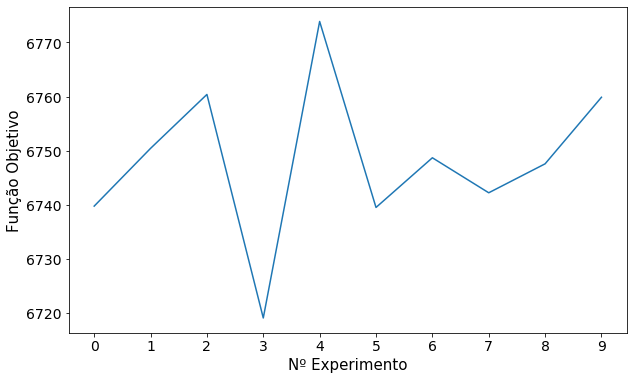

In [162]:
ax = pd.DataFrame(adequacy_criterions_multiviews).plot(figsize=(10,6),
                                       xticks=range(num_max_experiments),
                                      fontsize=14,
                                      legend=False)

ax.set_xlabel("Nº Experimento", fontsize=15)
ax.set_ylabel("Função Objetivo", fontsize=15)
plt.show()

In [163]:
num_iter_best_exp = best_multiviews.iterations + 1
print("Nº iterações do melhor experimento:", num_iter_best_exp)

np.savetxt(path_results_multiviews + 'num_iter_melhor_exp.csv', [num_iter_best_exp], delimiter=',')

Nº iterações do melhor experimento: 6


In [164]:
np.savetxt(path_results_multiviews + "funcao_obj.csv", adequacy_criterions_multiviews, delimiter=",")

### Set-medoids (Protótipos)

In [165]:
best_multiviews.prototypes

array([[ 692, 1864],
       [1722, 1689],
       [ 449,  436],
       [1765, 1655],
       [1717, 1715],
       [1662, 1627],
       [1890, 1831],
       [ 661,  753],
       [ 588,  504],
       [1885, 1993]])

In [166]:
print("Set-medoids (protótipos):\n")
for num_cluster in range(K):
    print('Q' + str(num_cluster+1) + ":", best_multiviews.prototypes[num_cluster])

Set-medoids (protótipos):

Q1: [ 692 1864]
Q2: [1722 1689]
Q3: [449 436]
Q4: [1765 1655]
Q5: [1717 1715]
Q6: [1662 1627]
Q7: [1890 1831]
Q8: [661 753]
Q9: [588 504]
Q10: [1885 1993]


In [167]:
np.savetxt(path_results_multiviews + "prototipos.csv", best_multiviews.prototypes, delimiter=",")

### Partição Fuzzy

In [168]:
best_multiviews.fuzzy_partition

array([[0.08760034, 0.12734084, 0.08204584, ..., 0.07752916, 0.08439179,
        0.10182012],
       [0.08373651, 0.13047288, 0.0835423 , ..., 0.07502456, 0.08126475,
        0.10241487],
       [0.0899679 , 0.12121461, 0.08736924, ..., 0.07650654, 0.0897374 ,
        0.10222887],
       ...,
       [0.10990088, 0.0924898 , 0.08612685, ..., 0.09437163, 0.08578653,
        0.14398889],
       [0.10669456, 0.08853812, 0.08058692, ..., 0.09025353, 0.07144169,
        0.16348344],
       [0.09350296, 0.08086174, 0.10542743, ..., 0.10225797, 0.10448067,
        0.10002219]])

In [169]:
memberships_sums = best_multiviews.fuzzy_partition.sum(axis=1)
memberships_sums

array([1., 1., 1., ..., 1., 1., 1.])

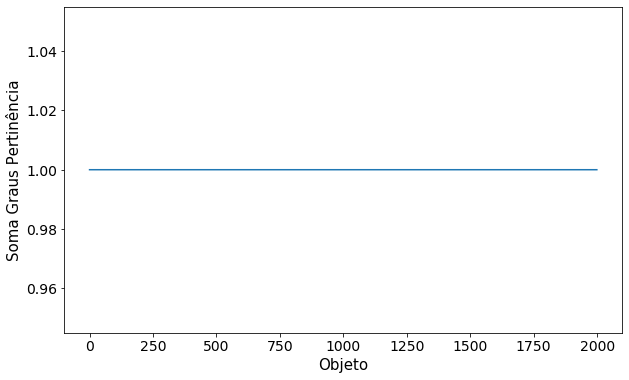

In [170]:
# Os graus de pertinência de cada objeto devem somar 1.
ax = pd.DataFrame(memberships_sums).plot(figsize=(10,6),
                                      fontsize=14,
                                      legend=False)

ax.set_xlabel("Objeto", fontsize=15)
ax.set_ylabel("Soma Graus Pertinência", fontsize=15)
plt.show()

In [171]:
# Os que não somam, é devido a erros numéricos.
memberships_sums.min(), memberships_sums.max()

(0.9999999999999998, 1.0000000000000002)

In [172]:
np.savetxt(path_results_multiviews + "particao_fuzzy.csv", best_multiviews.fuzzy_partition, delimiter=",")

### Partição Crisp

In [173]:
best_multiviews.fuzzy_to_crisp()
best_multiviews.crisp_partition

array([3, 5, 3, ..., 9, 9, 6])

In [174]:
print("Lista de Objetos por Grupo:\n")

crisp_clusters_multiviews = [np.where(best_multiviews.crisp_partition == k)[0] for k in range(K)]

for k in range(K): 
    print('Q' + str(k+1) + ":", crisp_clusters_multiviews[k], '\n')

Lista de Objetos por Grupo:

Q1: [ 203  204  205  209  219  220  221  223  225  227  229  231  234  238
  239  240  244  250  252  253  254  259  262  263  265  269  270  271
  273  286  289  291  294  303  307  310  311  314  319  320  321  323
  327  332  334  339  341  345  350  358  363  368  370  374  379  381
  386  389  394  395  396  399  648  657  692  702  713  716  730  733
  799  806  811  814  816  826  830  832  835  848  850  858  860  864
  872  876  882  883  886  887  891  912  916  920  924  930  931  946
  955  963  964  971  977  984  986  997 1002 1016 1018 1021 1027 1033
 1035 1038 1039 1041 1043 1045 1049 1050 1052 1055 1057 1059 1060 1064
 1069 1083 1089 1098 1106 1110 1114 1115 1126 1130 1133 1135 1138 1140
 1143 1145 1149 1150 1151 1155 1159 1168 1173 1180 1185 1194 1222 1290
 1330 1390 1609 1696 1818 1825 1830 1846 1864 1896 1914 1915 1917 1919
 1929 1945 1954 1995] 

Q2: [   7   15   20   21   28   29   38   39   54   57   58   62   64   67
   71   74   77 

In [175]:
print("Número de Objetos em cada Grupo Crisp: \n")

num_objects_crisp_multiviews = [cluster.shape[0] for cluster in crisp_clusters_multiviews]

for k in range(K):
    
    print('Q' + str(k+1) + ":", num_objects_crisp_multiviews[k])

Número de Objetos em cada Grupo Crisp: 

Q1: 172
Q2: 116
Q3: 88
Q4: 260
Q5: 293
Q6: 96
Q7: 352
Q8: 310
Q9: 212
Q10: 101


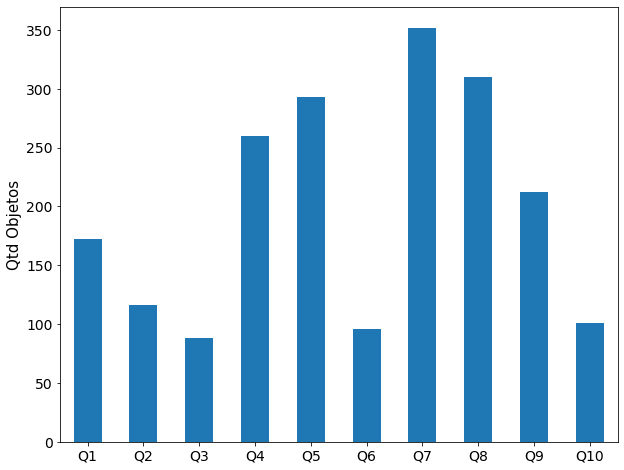

In [177]:
ax = pd.DataFrame(num_objects_crisp_multiviews).plot.bar(figsize=(10,8),
                                              fontsize=14,
                                              legend=False,
                                              rot=0)
        
ax.set_xticklabels(['Q' + str(k+1) for k in range(K)])
ax.set_ylabel("Qtd Objetos", fontsize=15)
plt.show()

In [178]:
np.savetxt(path_results_multiviews + "particao_crisp.csv", best_multiviews.crisp_partition, delimiter=",")

### Pesos das Matrizes

In [179]:
best_multiviews.relevance_weights

array([[0.62246813, 1.17706584, 1.36484119],
       [0.66463982, 1.1380216 , 1.32209644],
       [0.64758757, 1.15553144, 1.33634851],
       [0.65264491, 1.13459584, 1.35046042],
       [0.6303075 , 1.18155078, 1.34274991],
       [0.64947335, 1.16948752, 1.31656733],
       [0.59918283, 1.15031546, 1.4508539 ],
       [0.61623196, 1.18176457, 1.37317161],
       [0.63628626, 1.20214655, 1.30734449],
       [0.62693591, 1.1563272 , 1.3794187 ]])

In [180]:
weights_prod = best_multiviews.relevance_weights.prod(axis=1)
weights_prod

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

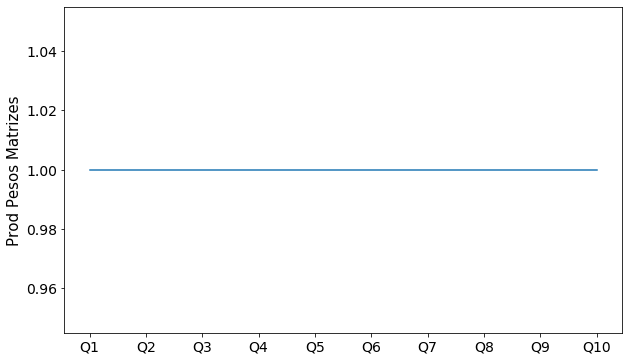

In [181]:
# O produto dos pesos das matrizes para cada cluster deve ser 1.
ax = pd.DataFrame(weights_prod).plot(figsize=(10,6),
                                      fontsize=14,
                                    xticks = range(10),
                                      legend=False)

ax.set_xticklabels(['Q' + str(k+1) for k in range(K)])
ax.set_ylabel("Prod Pesos Matrizes", fontsize=15)
plt.show()

In [182]:
# Os que não resultam em 1, é devido a erros numéricos.
weights_prod.min(), weights_prod.max()

(0.9999999999999988, 0.9999999999999994)

In [183]:
cols = ['View'+ str(i+1) for i in range(p)]

pd.DataFrame(best_multiviews.relevance_weights, columns=cols, 
             index = ['Q' + str(k+1) for k in range(K)])

,View1,View2,View3
Q1,0.622468,1.177066,1.364841
Q2,0.664640,1.138022,1.322096
Q3,0.647588,1.155531,1.336349
Q4,0.652645,1.134596,1.350460
Q5,0.630308,1.181551,1.342750
Q6,0.649473,1.169488,1.316567
Q7,0.599183,1.150315,1.450854
Q8,0.616232,1.181765,1.373172
Q9,0.636286,1.202147,1.307344
Q10,0.626936,1.156327,1.379419


In [184]:
np.savetxt(path_results_multiviews + "pesos_matrizes.csv", best_multiviews.relevance_weights, delimiter=",")

### Métricas

In [185]:
measures_multiviews = []

#### Métricas Internas

Modified Partition Coefficient

In [186]:
mpc = best_multiviews.mod_partition_coeff()
mpc

0.01406667299619635

In [187]:
measures_multiviews.append(mpc)

Partition Entropy

In [188]:
pe = best_multiviews.partition_entropy()
pe

2.2625000583814696

In [189]:
measures_multiviews.append(pe)

#### Métricas Externas

In [190]:
best_multiviews.confusion_matrix()

cols =  ['Q' + str(k+1) for k in range(K)] + ['Soma']
indexes = ['P' + str(k+1) for k in range(K)] + ['Soma']

pd.DataFrame(best_multiviews.expand_confusion_matrix, columns=cols, index=indexes)

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Soma
P1,0,47,0,137,2,14,0,0,0,0,200
P2,62,3,1,0,15,7,55,35,9,13,200
P3,0,0,52,0,0,1,1,0,146,0,200
P4,9,0,0,0,2,0,1,186,2,0,200
P5,35,4,5,4,116,1,0,22,3,10,200
P6,46,12,2,7,11,0,36,41,6,39,200
P7,4,19,0,14,136,16,1,2,5,3,200
P8,0,0,28,0,0,0,112,24,36,0,200
P9,2,31,0,96,11,57,1,0,2,0,200
P10,14,0,0,2,0,0,145,0,3,36,200


Índice de Rand Corrigido

In [191]:
ar_index = best_multiviews.adjusted_rand_index()
ar_index

0.3326660520935902

In [192]:
measures_multiviews.append(ar_index)

F-measure

In [193]:
f1 = best_multiviews.f_measure()
f1

0.4997134446517348

In [194]:
measures_multiviews.append(f1)

Erro de Atribuição

In [195]:
error_rate = best_multiviews.classification_error_rate()
error_rate

0.49650000000000005

In [196]:
measures_multiviews.append(error_rate)

#### Métricas Sumarizadas

In [197]:
measures_multiviews

[0.01406667299619635,
 2.2625000583814696,
 0.3326660520935902,
 0.4997134446517348,
 0.49650000000000005]

In [198]:
cols = ['Mod Partition Coeff', 'Partition Entropy', 'Indice Rand Corr',
        'F-measure', 'Erro Atribuição']

pd.DataFrame(measures_multiviews, index = cols).T

,Mod Partition Coeff,Partition Entropy,Indice Rand Corr,F-measure,Erro Atribuição
0,0.014067,2.2625,0.332666,0.499713,0.4965


## Persistir Objeto do Experimento

In [199]:
exp_object_file = open(path_results_multiviews + "experiment_object", "wb")

pickle.dump(best_multiviews, exp_object_file)

exp_object_file.close()

# Experimento com a View1 Individualmente

In [42]:
dissim_matrices = [view1_dissim_matrix]
p = len(dissim_matrices)

G = Lambda = U = None

best_view1, adequacy_criterions_view1 = run_experiments()

EXPERIMENTO 0
0
1
2
EXPERIMENTO 1
0
1
2
EXPERIMENTO 2
0
1
2
EXPERIMENTO 3
0
1
2
EXPERIMENTO 4
0
1
2
EXPERIMENTO 5
0
1
2
EXPERIMENTO 6
0
1
2
EXPERIMENTO 7
0
1
2
EXPERIMENTO 8
0
1
EXPERIMENTO 9
0
1
2


## Resultados

In [45]:
path_results_view1 = "results_view1/"

### Função Objetivo

In [46]:
adequacy_criterions_view1 = np.array(adequacy_criterions_view1)
adequacy_criterions_view1

array([3417.65321444, 3446.71243929, 3429.82005819, 3446.54581318,
       3422.90615145, 3446.79631039, 3422.97026395, 3436.91377552,
       3421.69323835, 3445.40591384])

In [47]:
min_J = adequacy_criterions_view1.min()
max_J = adequacy_criterions_view1.max()
mean_J = adequacy_criterions_view1.mean()
std_J = adequacy_criterions_view1.std()

cols = columns=['Mínimo', 'Máximo', 'Média', 'Desvio-padrão']
pd.DataFrame([[min_J, max_J, mean_J, std_J]], columns=cols)

,Mínimo,Máximo,Média,Desvio-padrão
0,3417.653214,3446.79631,3433.741718,11.408511


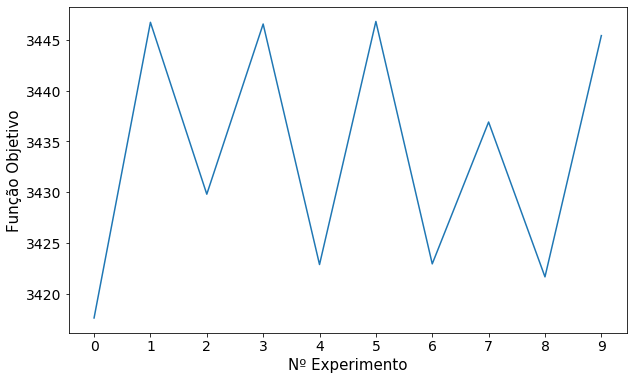

In [48]:
ax = pd.DataFrame(adequacy_criterions_view1).plot(figsize=(10,6),
                                       xticks=range(num_max_experiments),
                                      fontsize=14,
                                      legend=False)

ax.set_xlabel("Nº Experimento", fontsize=15)
ax.set_ylabel("Função Objetivo", fontsize=15)
plt.show()

In [49]:
num_iter_best_exp = best_view1.iterations + 1
print("Nº iterações do melhor experimento:", num_iter_best_exp)

np.savetxt(path_results_view1 + 'num_iter_melhor_exp.csv', [num_iter_best_exp], delimiter=',')

Nº iterações do melhor experimento: 3


In [50]:
np.savetxt(path_results_view1 + "funcao_obj.csv", adequacy_criterions_view1, delimiter=",")

### Set-medoids (Protótipos)

In [52]:
best_view1.prototypes

array([[ 749,  797],
       [1722, 1689],
       [1025, 1658],
       [ 436,  593],
       [1655, 1798],
       [ 426,  512],
       [1764, 1760],
       [1693, 1799],
       [ 695,  772],
       [1825, 1959]])

In [53]:
print("Set-medoids (protótipos):\n")
for num_cluster in range(K):
    print('Q' + str(num_cluster+1) + ":", best_view1.prototypes[num_cluster])

Set-medoids (protótipos):

Q1: [749 797]
Q2: [1722 1689]
Q3: [1025 1658]
Q4: [436 593]
Q5: [1655 1798]
Q6: [426 512]
Q7: [1764 1760]
Q8: [1693 1799]
Q9: [695 772]
Q10: [1825 1959]


In [54]:
np.savetxt(path_results_view1 + "prototipos.csv", best_view1.prototypes, delimiter=",")

### Partição Fuzzy

In [55]:
best_view1.fuzzy_partition

array([[0.053855  , 0.14277392, 0.10690863, ..., 0.12626142, 0.06796859,
        0.07364616],
       [0.05450686, 0.15291145, 0.10332908, ..., 0.11658175, 0.06446262,
        0.07821587],
       [0.05501307, 0.13767718, 0.10246666, ..., 0.14811244, 0.06889393,
        0.07524029],
       ...,
       [0.11450192, 0.08783213, 0.10209005, ..., 0.07748494, 0.08523386,
        0.16261202],
       [0.0956867 , 0.0884174 , 0.09564499, ..., 0.0771466 , 0.0953133 ,
        0.21313286],
       [0.1348869 , 0.06833755, 0.06931932, ..., 0.0616101 , 0.08348092,
        0.12043525]])

In [56]:
memberships_sums = best_view1.fuzzy_partition.sum(axis=1)
memberships_sums

array([1., 1., 1., ..., 1., 1., 1.])

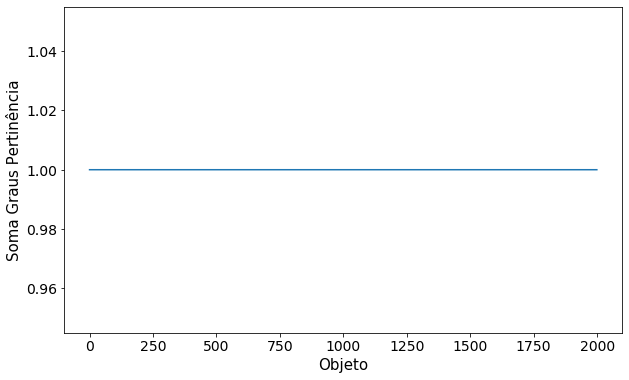

In [57]:
# Os graus de pertinência de cada objeto devem somar 1.
ax = pd.DataFrame(memberships_sums).plot(figsize=(10,6),
                                      fontsize=14,
                                      legend=False)

ax.set_xlabel("Objeto", fontsize=15)
ax.set_ylabel("Soma Graus Pertinência", fontsize=15)
plt.show()

In [58]:
# Os que não somam, é devido a erros numéricos.
memberships_sums.min(), memberships_sums.max()

(0.9999999999999998, 1.0000000000000002)

In [59]:
np.savetxt(path_results_view1 + "particao_fuzzy.csv", best_view1.fuzzy_partition, delimiter=",")

### Partição Crisp

In [60]:
best_view1.fuzzy_to_crisp()
best_view1.crisp_partition

array([6, 6, 6, ..., 9, 9, 5])

In [61]:
print("Lista de Objetos por Grupo:\n")

crisp_clusters_view1 = [np.where(best_view1.crisp_partition == k)[0] for k in range(K)]

for k in range(K): 
    print('Q' + str(k+1) + ":", crisp_clusters_view1[k], '\n')

Lista de Objetos por Grupo:

Q1: [ 201  203  204  210  211  212  214  215  216  217  218  222  223  224
  226  227  229  230  231  232  233  234  237  238  240  241  242  244
  246  248  249  256  257  258  261  263  267  268  270  274  275  278
  279  280  283  284  285  287  289  294  297  299  300  303  304  305
  306  308  309  310  311  314  316  322  324  325  326  328  329  333
  334  339  340  341  342  345  346  348  349  351  353  354  356  361
  362  365  368  372  373  374  376  384  386  388  390  391  392  393
  396  399  604  608  610  613  614  619  623  626  628  629  637  640
  641  642  643  644  653  655  656  661  663  665  666  672  674  677
  679  681  687  689  693  701  707  714  721  722  723  727  728  729
  731  732  734  738  739  741  742  746  749  750  751  752  753  756
  757  760  761  762  763  764  765  767  773  775  778  782  786  788
  790  793  794  795  796  797  803  837  846  872  877  888  943  957
  974 1004 1006 1008 1010 1019 1022 1024 102

In [62]:
print("Número de Objetos em cada Grupo Crisp: \n")

num_objects_crisp_view1 = [cluster.shape[0] for cluster in crisp_clusters_view1]

for k in range(K):
    
    print('Q' + str(k+1) + ":", num_objects_crisp_view1[k])

Número de Objetos em cada Grupo Crisp: 

Q1: 221
Q2: 67
Q3: 172
Q4: 303
Q5: 145
Q6: 222
Q7: 207
Q8: 248
Q9: 222
Q10: 193


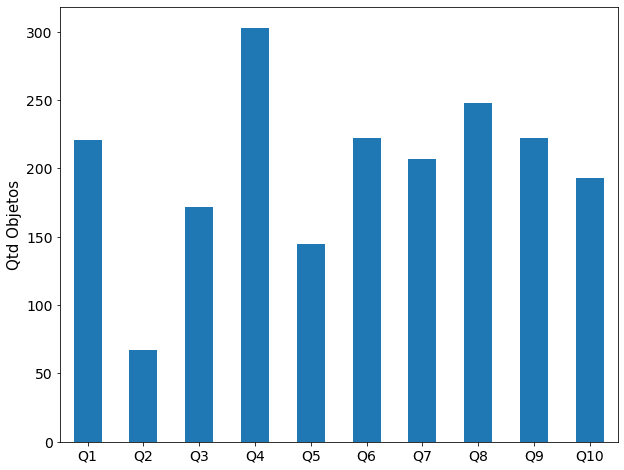

In [63]:
ax = pd.DataFrame(num_objects_crisp_view1).plot.bar(figsize=(10,8),
                                              fontsize=14,
                                              legend=False,
                                              rot=0)
        
ax.set_xticklabels(['Q' + str(k+1) for k in range(K)])
ax.set_ylabel("Qtd Objetos", fontsize=15)
plt.show()

In [64]:
np.savetxt(path_results_view1 + "particao_crisp.csv", best_view1.crisp_partition, delimiter=",")

### Pesos das Matrizes

In [65]:
best_view1.relevance_weights

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

### Métricas

In [66]:
measures_view1 = []

#### Métricas Internas

Modified Partition Coefficient

In [67]:
mpc = best_view1.mod_partition_coeff()
mpc

0.022069337847517856

In [68]:
measures_view1.append(mpc)

Partition Entropy

In [69]:
pe = best_view1.partition_entropy()
pe

2.229448939966565

In [70]:
measures_view1.append(pe)

#### Métricas Externas

In [71]:
best_view1.confusion_matrix()

cols =  ['Q' + str(k+1) for k in range(K)] + ['Soma']
indexes = ['P' + str(k+1) for k in range(K)] + ['Soma']

pd.DataFrame(best_view1.expand_confusion_matrix, columns=cols, index=indexes)

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Soma
P1,0,3,0,1,0,0,166,30,0,0,200
P2,100,6,4,13,2,0,0,2,55,18,200
P3,0,0,0,171,0,29,0,0,0,0,200
P4,74,2,2,8,0,1,1,0,109,3,200
P5,9,5,30,39,0,0,1,107,6,3,200
P6,30,2,87,10,0,6,5,5,40,15,200
P7,0,8,47,4,56,0,0,83,2,0,200
P8,4,0,0,42,0,138,0,0,0,16,200
P9,1,41,1,7,86,0,34,21,6,3,200
P10,3,0,1,8,1,48,0,0,4,135,200


Índice de Rand Corrigido

In [72]:
ar_index = best_view1.adjusted_rand_index()
ar_index

0.3585756050730023

In [73]:
measures_view1.append(ar_index)

F-measure

In [74]:
f1 = best_view1.f_measure()
f1

0.5642850635628067

In [75]:
measures_view1.append(f1)

Erro de Atribuição

In [76]:
error_rate = best_view1.classification_error_rate()
error_rate

0.43000000000000005

In [77]:
measures_view1.append(error_rate)

#### Métricas Sumarizadas

In [78]:
measures_view1

[0.022069337847517856,
 2.229448939966565,
 0.3585756050730023,
 0.5642850635628067,
 0.43000000000000005]

In [79]:
cols = ['Mod Partition Coeff', 'Partition Entropy', 'Indice Rand Corr',
        'F-measure', 'Erro Atribuição']

pd.DataFrame(measures_view1, index = cols).T

,Mod Partition Coeff,Partition Entropy,Indice Rand Corr,F-measure,Erro Atribuição
0,0.022069,2.229449,0.358576,0.564285,0.43


## Persistir Objeto do Experimento

In [80]:
exp_object_file = open(path_results_view1 + "experiment_object", "wb")

pickle.dump(best_view1, exp_object_file)

exp_object_file.close()

# Experimento com a View2 Individualmente

In [43]:
dissim_matrices = [view2_dissim_matrix]
p = len(dissim_matrices)

G = Lambda = U = None

best_view2, adequacy_criterions_view2 = run_experiments()

EXPERIMENTO 0
0
1
EXPERIMENTO 1
0
1
EXPERIMENTO 2
0
1
EXPERIMENTO 3
0
1
EXPERIMENTO 4
0
1
EXPERIMENTO 5
0
1
EXPERIMENTO 6
0
1
EXPERIMENTO 7
0
1
EXPERIMENTO 8
0
1
EXPERIMENTO 9
0
1


## Resultados

In [83]:
path_results_view2 = "results_view2/"

### Função Objetivo

In [84]:
adequacy_criterions_view2 = np.array(adequacy_criterions_view2)
adequacy_criterions_view2

array([1837.11273755, 1838.06443829, 1833.21592169, 1834.2827316 ,
       1837.03052134, 1835.95401327, 1836.11449862, 1835.228456  ,
       1838.02711455, 1840.25835689])

In [85]:
min_J = adequacy_criterions_view2.min()
max_J = adequacy_criterions_view2.max()
mean_J = adequacy_criterions_view2.mean()
std_J = adequacy_criterions_view2.std()

cols = columns=['Mínimo', 'Máximo', 'Média', 'Desvio-padrão']
pd.DataFrame([[min_J, max_J, mean_J, std_J]], columns=cols)

,Mínimo,Máximo,Média,Desvio-padrão
0,1833.215922,1840.258357,1836.528879,1.931796


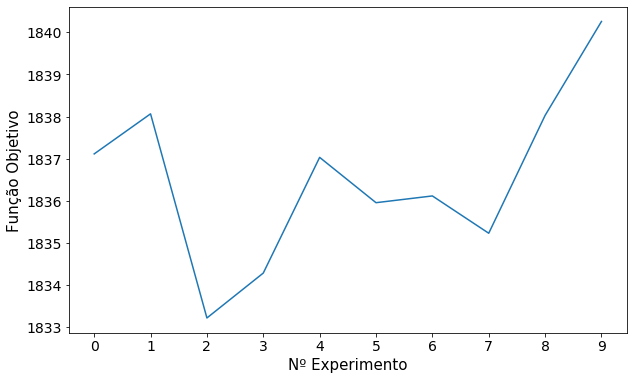

In [86]:
ax = pd.DataFrame(adequacy_criterions_view2).plot(figsize=(10,6),
                                       xticks=range(num_max_experiments),
                                      fontsize=14,
                                      legend=False)

ax.set_xlabel("Nº Experimento", fontsize=15)
ax.set_ylabel("Função Objetivo", fontsize=15)
plt.show()

In [87]:
num_iter_best_exp = best_view2.iterations + 1
print("Nº iterações do melhor experimento:", num_iter_best_exp)

np.savetxt(path_results_view2 + 'num_iter_melhor_exp.csv', [num_iter_best_exp], delimiter=',')

Nº iterações do melhor experimento: 2


In [88]:
np.savetxt(path_results_view2 + "funcao_obj.csv", adequacy_criterions_view2, delimiter=",")

### Set-medoids (Protótipos)

In [89]:
best_view2.prototypes

array([[ 392,  374],
       [ 296, 1717],
       [ 817,  525],
       [ 661,  692],
       [ 395,  384],
       [ 315,  321],
       [1907,  347],
       [ 242, 1391],
       [ 131,   57],
       [1596, 1445]])

In [90]:
print("Set-medoids (protótipos):\n")
for num_cluster in range(K):
    print('Q' + str(num_cluster+1) + ":", best_view2.prototypes[num_cluster])

Set-medoids (protótipos):

Q1: [392 374]
Q2: [ 296 1717]
Q3: [817 525]
Q4: [661 692]
Q5: [395 384]
Q6: [315 321]
Q7: [1907  347]
Q8: [ 242 1391]
Q9: [131  57]
Q10: [1596 1445]


In [91]:
np.savetxt(path_results_view2 + "prototipos.csv", best_view2.prototypes, delimiter=",")

### Partição Fuzzy

In [92]:
best_view2.fuzzy_partition

array([[0.0925359 , 0.09546864, 0.08880092, ..., 0.09078049, 0.19550401,
        0.07976987],
       [0.09650009, 0.09305484, 0.09530142, ..., 0.09467237, 0.17234641,
        0.08415896],
       [0.10080376, 0.10235155, 0.09641962, ..., 0.09651303, 0.14565295,
        0.08577931],
       ...,
       [0.0986488 , 0.09430709, 0.10477317, ..., 0.10775621, 0.09057122,
        0.0996972 ],
       [0.09553123, 0.10007099, 0.10962205, ..., 0.11933282, 0.07899722,
        0.10203966],
       [0.10225348, 0.12453279, 0.10259075, ..., 0.10332448, 0.07363437,
        0.0946346 ]])

In [93]:
memberships_sums = best_view2.fuzzy_partition.sum(axis=1)
memberships_sums

array([1., 1., 1., ..., 1., 1., 1.])

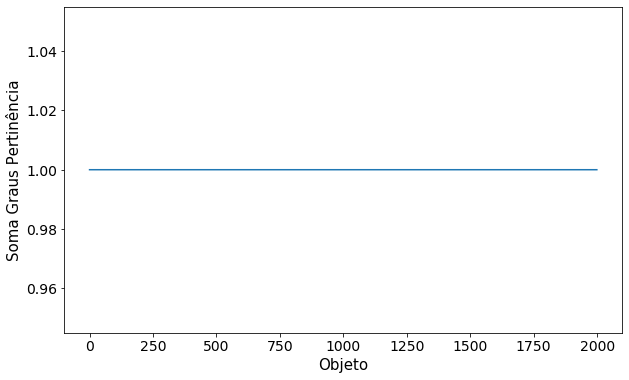

In [94]:
# Os graus de pertinência de cada objeto devem somar 1.
ax = pd.DataFrame(memberships_sums).plot(figsize=(10,6),
                                      fontsize=14,
                                      legend=False)

ax.set_xlabel("Objeto", fontsize=15)
ax.set_ylabel("Soma Graus Pertinência", fontsize=15)
plt.show()

In [95]:
# Os que não somam, é devido a erros numéricos.
memberships_sums.min(), memberships_sums.max()

(0.9999999999999998, 1.0000000000000002)

In [96]:
np.savetxt(path_results_view2 + "particao_fuzzy.csv", best_view2.fuzzy_partition, delimiter=",")

### Partição Crisp

In [97]:
best_view2.fuzzy_to_crisp()
best_view2.crisp_partition

array([8, 8, 8, ..., 7, 7, 1])

In [98]:
print("Lista de Objetos por Grupo:\n")

crisp_clusters_view2 = [np.where(best_view2.crisp_partition == k)[0] for k in range(K)]

for k in range(K):
    print('Q' + str(k+1) + ":", crisp_clusters_view2[k], '\n')

Lista de Objetos por Grupo:

Q1: [ 203  204  208  213  217  218  227  228  233  234  238  248  249  256
  257  262  263  264  266  268  270  273  278  280  284  285  286  289
  291  294  295  300  302  311  314  324  326  329  339  341  343  346
  355  356  357  368  369  372  373  374  378  381  385  386  388  392
  397  416  568  605  608  611  618  639  649  660  687  688  705  708
  737  768  774  776  814  824  825  855  856  859  868  876  891  908
  912  913  930  934  955  966  968  975  977  997  999 1011 1012 1021
 1023 1026 1033 1039 1042 1046 1048 1054 1056 1063 1078 1079 1081 1084
 1088 1089 1097 1108 1130 1132 1142 1162 1175 1176 1194 1197 1213 1215
 1216 1287 1293 1296 1317 1323 1329 1339 1367 1616 1624 1625 1639 1643
 1646 1667 1680 1695 1696 1698 1702 1703 1727 1736 1741 1753 1757 1793
 1802 1849 1870 1872 1884 1912 1918] 

Q2: [ 210  229  232  235  236  240  244  255  274  296  304  310  313  316
  353  377  396  607  617  635  659  666  677  758  837  872  951 1044
 

In [99]:
print("Número de Objetos em cada Grupo Crisp: \n")

num_objects_crisp_view2 = [cluster.shape[0] for cluster in crisp_clusters_view2]

for k in range(K):
    
    print('Q' + str(k+1) + ":", num_objects_crisp_view2[k])

Número de Objetos em cada Grupo Crisp: 

Q1: 161
Q2: 110
Q3: 251
Q4: 328
Q5: 121
Q6: 131
Q7: 45
Q8: 261
Q9: 353
Q10: 239


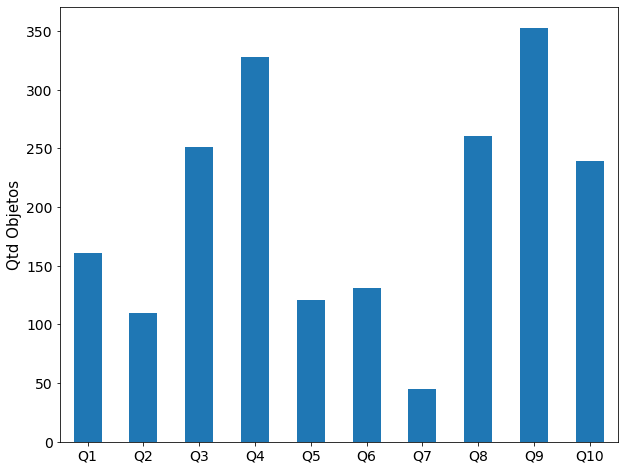

In [101]:
ax = pd.DataFrame(num_objects_crisp_view2).plot.bar(figsize=(10,8),
                                              fontsize=14,
                                              legend=False,
                                              rot=0)
        
ax.set_xticklabels(['Q' + str(k+1) for k in range(K)])
ax.set_ylabel("Qtd Objetos", fontsize=15)
plt.show()

In [102]:
np.savetxt(path_results_view2 + "particao_crisp.csv", best_view2.crisp_partition, delimiter=",")

### Pesos das Matrizes

In [103]:
best_view2.relevance_weights

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

### Métricas

In [104]:
measures_view2 = []

#### Métricas Internas

Modified Partition Coefficient

In [105]:
mpc = best_view2.mod_partition_coeff()
mpc

0.012285447708433983

In [106]:
measures_view2.append(mpc)

Partition Entropy

In [107]:
pe = best_view2.partition_entropy()
pe

2.2702021227540183

In [108]:
measures_view2.append(pe)

#### Métricas Externas

In [109]:
best_view2.confusion_matrix()

cols =  ['Q' + str(k+1) for k in range(K)] + ['Soma']
indexes = ['P' + str(k+1) for k in range(K)] + ['Soma']

pd.DataFrame(best_view2.expand_confusion_matrix, columns=cols, index=indexes)

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Soma
P1,0,0,0,0,0,0,0,0,200,0,200
P2,57,17,11,5,33,39,4,12,0,22,200
P3,2,0,30,1,39,48,0,1,0,79,200
P4,15,7,9,137,6,10,4,4,0,8,200
P5,21,3,82,27,20,12,6,22,2,5,200
P6,29,7,16,64,23,8,16,34,1,2,200
P7,11,19,31,42,0,1,6,89,0,1,200
P8,0,0,48,3,0,11,0,18,0,120,200
P9,19,28,0,3,0,0,0,0,149,1,200
P10,7,29,24,46,0,2,9,81,1,1,200


Índice de Rand Corrigido

In [110]:
ar_index = best_view2.adjusted_rand_index()
ar_index

0.26462750150567527

In [111]:
measures_view2.append(ar_index)

F-measure

In [112]:
f1 = best_view2.f_measure()
f1

0.4347128659485023

In [113]:
measures_view2.append(f1)

Erro de Atribuição

In [114]:
error_rate = best_view2.classification_error_rate()
error_rate

0.5915

In [115]:
measures_view2.append(error_rate)

#### Métricas Sumarizadas

In [116]:
measures_view2

[0.012285447708433983,
 2.2702021227540183,
 0.26462750150567527,
 0.4347128659485023,
 0.5915]

In [117]:
cols = ['Mod Partition Coeff', 'Partition Entropy', 'Indice Rand Corr',
        'F-measure', 'Erro Atribuição']

pd.DataFrame(measures_view2, index = cols).T

,Mod Partition Coeff,Partition Entropy,Indice Rand Corr,F-measure,Erro Atribuição
0,0.012285,2.270202,0.264628,0.434713,0.5915


## Persistir Objeto do Experimento

In [118]:
exp_object_file = open(path_results_view2 + "experiment_object", "wb")

pickle.dump(best_view2, exp_object_file)

exp_object_file.close()

# Experimento com a View3 Individualmente

In [44]:
dissim_matrices = [view3_dissim_matrix]
p = len(dissim_matrices)

G = Lambda = U = None

best_view3, adequacy_criterions_view3 = run_experiments()

EXPERIMENTO 0
0
1
EXPERIMENTO 1
0
1
EXPERIMENTO 2
0
1
EXPERIMENTO 3
0
1
EXPERIMENTO 4
0
1
EXPERIMENTO 5
0
1
EXPERIMENTO 6
0
1
EXPERIMENTO 7
0
1
2
EXPERIMENTO 8
0
1
EXPERIMENTO 9
0
1


## Resultados

In [120]:
path_results_view3 = "results_view3/"

### Função Objetivo

In [121]:
adequacy_criterions_view3 = np.array(adequacy_criterions_view3)
adequacy_criterions_view3

array([1553.850915  , 1556.14045953, 1551.45105681, 1553.91102535,
       1555.64247337, 1551.25663616, 1555.88459113, 1555.06519323,
       1556.05355777, 1548.48235444])

In [122]:
min_J = adequacy_criterions_view3.min()
max_J = adequacy_criterions_view3.max()
mean_J = adequacy_criterions_view3.mean()
std_J = adequacy_criterions_view3.std()

cols = columns=['Mínimo', 'Máximo', 'Média', 'Desvio-padrão']
pd.DataFrame([[min_J, max_J, mean_J, std_J]], columns=cols)

,Mínimo,Máximo,Média,Desvio-padrão
0,1548.482354,1556.14046,1553.773826,2.452934


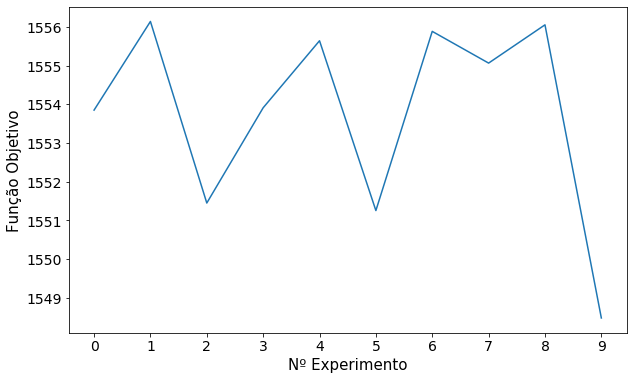

In [123]:
ax = pd.DataFrame(adequacy_criterions_view3).plot(figsize=(10,6),
                                       xticks=range(num_max_experiments),
                                      fontsize=14,
                                      legend=False)

ax.set_xlabel("Nº Experimento", fontsize=15)
ax.set_ylabel("Função Objetivo", fontsize=15)
plt.show()

In [124]:
num_iter_best_exp = best_view3.iterations + 1
print("Nº iterações do melhor experimento:", num_iter_best_exp)

np.savetxt(path_results_view3 + 'num_iter_melhor_exp.csv', [num_iter_best_exp], delimiter=',')

Nº iterações do melhor experimento: 2


In [125]:
np.savetxt(path_results_view3 + "funcao_obj.csv", adequacy_criterions_view3, delimiter=",")

### Set-medoids (Protótipos)

In [126]:
best_view3.prototypes

array([[  25,   78],
       [1789,   11],
       [ 654,  620],
       [1890, 1887],
       [  85,  117],
       [ 191,   55],
       [1494, 1831],
       [ 779,  678],
       [ 275,  354],
       [  35,  103]])

In [127]:
print("Set-medoids (protótipos):\n")
for num_cluster in range(K):
    print('Q' + str(num_cluster+1) + ":", best_view3.prototypes[num_cluster])

Set-medoids (protótipos):

Q1: [25 78]
Q2: [1789   11]
Q3: [654 620]
Q4: [1890 1887]
Q5: [ 85 117]
Q6: [191  55]
Q7: [1494 1831]
Q8: [779 678]
Q9: [275 354]
Q10: [ 35 103]


In [128]:
np.savetxt(path_results_view3 + "prototipos.csv", best_view3.prototypes, delimiter=",")

### Partição Fuzzy

In [129]:
best_view3.fuzzy_partition

array([[0.14798189, 0.08525234, 0.09394605, ..., 0.08695011, 0.07163927,
        0.11188879],
       [0.13367369, 0.09960495, 0.08353159, ..., 0.07336211, 0.09896266,
        0.12420765],
       [0.11554784, 0.12692763, 0.07573212, ..., 0.07641435, 0.07765703,
        0.09772491],
       ...,
       [0.12228187, 0.10166436, 0.08364819, ..., 0.08320404, 0.09114926,
        0.0972265 ],
       [0.10891954, 0.10222163, 0.08656469, ..., 0.08425452, 0.10534278,
        0.09990952],
       [0.08533003, 0.08848248, 0.0955031 , ..., 0.08603755, 0.0959857 ,
        0.08781492]])

In [130]:
memberships_sums = best_view3.fuzzy_partition.sum(axis=1)
memberships_sums

array([1., 1., 1., ..., 1., 1., 1.])

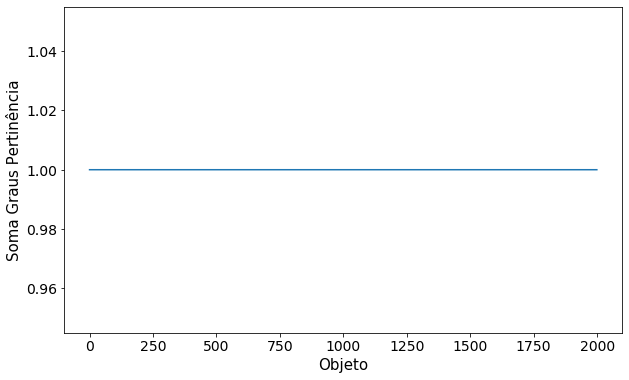

In [131]:
# Os graus de pertinência de cada objeto devem somar 1.
ax = pd.DataFrame(memberships_sums).plot(figsize=(10,6),
                                      fontsize=14,
                                      legend=False)

ax.set_xlabel("Objeto", fontsize=15)
ax.set_ylabel("Soma Graus Pertinência", fontsize=15)
plt.show()

In [132]:
# Os que não somam, é devido a erros numéricos.
memberships_sums.min(), memberships_sums.max()

(0.9999999999999998, 1.0000000000000002)

In [133]:
np.savetxt(path_results_view3 + "particao_fuzzy.csv", best_view3.fuzzy_partition, delimiter=",")

### Partição Crisp

In [134]:
best_view3.fuzzy_to_crisp()
best_view3.crisp_partition

array([0, 0, 4, ..., 3, 3, 3])

In [135]:
print("Lista de Objetos por Grupo:\n")

crisp_clusters_view3 = [np.where(best_view3.crisp_partition == k)[0] for k in range(K)]

for k in range(K): 
    print('Q' + str(k+1) + ":", crisp_clusters_view3[k], '\n')

Lista de Objetos por Grupo:

Q1: [   0    1    3    4    7    8   13   14   17   19   23   25   34   36
   37   39   47   49   51   53   58   59   60   67   71   73   78   82
   89   91   93   94   97   98   99  102  104  105  109  110  111  112
  113  114  120  122  123  124  126  127  128  129  139  141  146  148
  151  152  153  154  156  157  162  165  167  170  171  181  182  183
  186  187  190  192  194  195  199  409  419  428  432  440  442  445
  451  458  471  487  489  505  506  510  526  544  545  568  573  581
  586  605  715  774  801  804  812  823  829  836  862  869  893  908
  931  936  940  949  952  978  979  983  989  991 1000 1028 1031 1058
 1103 1125 1127 1131 1137 1158 1180 1202 1204 1205 1212 1213 1216 1217
 1221 1223 1224 1225 1235 1236 1238 1240 1243 1252 1254 1255 1257 1258
 1263 1273 1276 1277 1281 1282 1284 1288 1297 1307 1309 1313 1314 1319
 1320 1326 1333 1342 1343 1344 1347 1350 1353 1354 1357 1362 1363 1364
 1368 1369 1377 1380 1391 1395 1400 1607 161

In [136]:
print("Número de Objetos em cada Grupo Crisp: \n")

num_objects_crisp_view3 = [cluster.shape[0] for cluster in crisp_clusters_view3]

for k in range(K):
    
    print('Q' + str(k+1) + ":", num_objects_crisp_view3[k])

Número de Objetos em cada Grupo Crisp: 

Q1: 244
Q2: 168
Q3: 210
Q4: 275
Q5: 122
Q6: 150
Q7: 295
Q8: 183
Q9: 243
Q10: 110


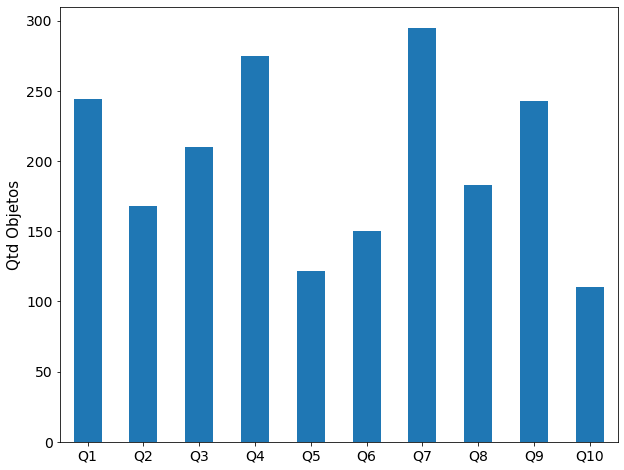

In [137]:
ax = pd.DataFrame(num_objects_crisp_view3).plot.bar(figsize=(10,8),
                                              fontsize=14,
                                              legend=False,
                                              rot=0)
        
ax.set_xticklabels(['Q' + str(k+1) for k in range(K)])
ax.set_ylabel("Qtd Objetos", fontsize=15)
plt.show()

In [138]:
np.savetxt(path_results_view3 + "particao_crisp.csv", best_view3.crisp_partition, delimiter=",")

### Pesos das Matrizes

In [139]:
best_view3.relevance_weights

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

### Métricas

In [140]:
measures_view3 = []

#### Métricas Internas

Modified Partition Coefficient

In [141]:
mpc = best_view3.mod_partition_coeff()
mpc

0.01286662835643404

In [142]:
measures_view3.append(mpc)

Partition Entropy

In [143]:
pe = best_view3.partition_entropy()
pe

2.2675171639387317

In [144]:
measures_view3.append(pe)

#### Métricas Externas

In [145]:
best_view3.confusion_matrix()

cols =  ['Q' + str(k+1) for k in range(K)] + ['Soma']
indexes = ['P' + str(k+1) for k in range(K)] + ['Soma']

pd.DataFrame(best_view3.expand_confusion_matrix, columns=cols, index=indexes)

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Soma
P1,77,15,0,0,52,37,0,1,3,15,200
P2,0,1,2,18,0,1,8,9,161,0,200
P3,22,49,2,4,6,34,61,2,10,10,200
P4,3,0,115,1,2,2,10,63,2,2,200
P5,20,9,5,29,5,12,3,41,38,38,200
P6,11,1,65,31,5,11,18,52,6,0,200
P7,55,22,8,0,34,32,0,11,4,34,200
P8,1,1,3,39,0,0,155,0,1,0,200
P9,47,65,7,12,18,20,2,3,15,11,200
P10,8,5,3,141,0,1,38,1,3,0,200


Índice de Rand Corrigido

In [146]:
ar_index = best_view3.adjusted_rand_index()
ar_index

0.25013492433128925

In [147]:
measures_view3.append(ar_index)

F-measure

In [148]:
f1 = best_view3.f_measure()
f1

0.4284179022068296

In [149]:
measures_view3.append(f1)

Erro de Atribuição

In [150]:
error_rate = best_view3.classification_error_rate()
error_rate

0.548

In [151]:
measures_view3.append(error_rate)

#### Métricas Sumarizadas

In [152]:
measures_view3

[0.01286662835643404,
 2.2675171639387317,
 0.25013492433128925,
 0.4284179022068296,
 0.548]

In [153]:
cols = ['Mod Partition Coeff', 'Partition Entropy', 'Indice Rand Corr',
        'F-measure', 'Erro Atribuição']

pd.DataFrame(measures_view3, index = cols).T

,Mod Partition Coeff,Partition Entropy,Indice Rand Corr,F-measure,Erro Atribuição
0,0.012867,2.267517,0.250135,0.428418,0.548


## Persistir Objeto do Experimento

In [154]:
exp_object_file = open(path_results_view3 + "experiment_object", "wb")

pickle.dump(best_view3, exp_object_file)

exp_object_file.close()

# Comparação dos Experimentos

In [214]:
measures_experiments = [measures_multiviews, measures_view1, 
                        measures_view2, measures_view3]

cols = ['Mod Partition Coeff', 'Partition Entropy', 'Indice Rand Corr',
        'F-measure', 'Erro Atribuição']

indexes = ['Multiviews','View1', 'View2', 'View3']

pd.DataFrame(measures_experiments, columns = cols, index = indexes)

,Mod Partition Coeff,Partition Entropy,Indice Rand Corr,F-measure,Erro Atribuição
Multiviews,0.014067,2.262500,0.332666,0.499713,0.4965
View1,0.022069,2.229449,0.358576,0.564285,0.4300
View2,0.012285,2.270202,0.264628,0.434713,0.5915
View3,0.012867,2.267517,0.250135,0.428418,0.5480
